In [1]:
!pip install datasets
!pip install transformers
!pip install librosa
!pip install evaluate
!pip install jiwer
!pip install gradio
!pip install noisereduce
!pip install -q bitsandbytes datasets accelerate loralib peft

In [2]:
from huggingface_hub import interpreter_login

interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token can be pasted using 'Right-Click'.


Enter your token (input will not be visible):  ········
Add token as git credential? (Y/n)  y


Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (manager).
Your token has been saved to C:\Users\aton\.cache\huggingface\token
Login successful


In [3]:
import torch

print(torch.cuda.is_available())

True


In [4]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
model_name = "openai/whisper-small"
language = 'indonesian'
task = "transcribe"

In [6]:
import pandas as pd

def tsv_to_df(tsv_file, test=False):
  df = pd.read_csv(tsv_file, sep='\t')
  if test:
    return df[:419]
  return df
    

In [ ]:
dev_tsv = 'your_path_here/dev.tsv'
test_tsv = 'your_path_here/test.tsv'
train_tsv = 'your_path_here/train.tsv'

In [8]:
train = tsv_to_df(train_tsv)
val = tsv_to_df(dev_tsv)

In [9]:
train = pd.concat([train, val], ignore_index=True)

In [10]:
len(train)

8392

In [11]:
test = tsv_to_df(test_tsv, test=True)

In [12]:
len(test)

419

In [ ]:
folder_path = 'your_folder_path/'  # Replace with the actual folder path where audio files are stored
train_audio_paths = folder_path + train['path']
test_audio_paths = folder_path + test['path']
train['path'] = train_audio_paths
test['path'] = test_audio_paths

In [14]:
print(len(train))
print(len(test))

8392
419


In [15]:
print(train['path'][1])

C:/Users/aton/OneDrive/Documents/Belajar/Python/Jupyter Notebook/Automatic Speech Recognition/audio-id/cv-corpus-18.0-2024-06-14/id/clips/common_voice_id_25378794.mp3


In [16]:
from datasets import DatasetDict, Dataset

train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)

datasets = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

In [17]:
print(datasets)

DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'sentence_id', 'sentence', 'sentence_domain', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment'],
        num_rows: 8392
    })
    test: Dataset({
        features: ['client_id', 'path', 'sentence_id', 'sentence', 'sentence_domain', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment'],
        num_rows: 419
    })
})


In [18]:
datasets = datasets.remove_columns(['client_id', 'sentence_id', 'sentence_domain', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment'])

In [19]:
print(datasets)

DatasetDict({
    train: Dataset({
        features: ['path', 'sentence'],
        num_rows: 8392
    })
    test: Dataset({
        features: ['path', 'sentence'],
        num_rows: 419
    })
})


In [20]:
from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperProcessor

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name)
tokenizer = WhisperTokenizer.from_pretrained(model_name, language=language, task=task)
processor = WhisperProcessor.from_pretrained(model_name, language=language, task=task)

In [21]:
import librosa

def prepare_dataset(batch):
    audio = batch["path"]

    audio, sr = librosa.load(audio, sr=16000)

    batch["input_features"] = feature_extractor(audio, sampling_rate=sr).input_features[0]

    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

In [22]:
datasets = datasets.map(prepare_dataset, remove_columns=datasets.column_names["train"], num_proc=1)

Map:   0%|          | 0/8392 [00:00<?, ? examples/s]

Map:   0%|          | 0/419 [00:00<?, ? examples/s]

In [23]:
train['sentence'][4]

'saya ingin mengerjakan pekerjaan kantor di kafe terdekat'

In [24]:
datasets

DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 8392
    })
    test: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 419
    })
})

In [25]:
datasets['train']['labels'][4]

[50258,
 50275,
 50359,
 50363,
 82,
 4427,
 3957,
 259,
 1706,
 1321,
 73,
 14910,
 520,
 5767,
 2938,
 282,
 44055,
 284,
 1026,
 6799,
 2106,
 1796,
 67,
 916,
 267,
 50257]

In [26]:
decoded_labels = tokenizer.decode(datasets['train']['labels'][4], skip_special_tokens=True)

In [27]:
decoded_labels

'saya ingin mengerjakan pekerjaan kantor di kafe terdekat'

In [28]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
  processor: Any
  def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
    input_values = [{'input_features': feature['input_features']} for feature in features]
    batch = self.processor.feature_extractor.pad(input_values, return_tensors='pt')

    labels_features = [{'input_ids': feature['labels']} for feature in features]
    labels_batch = self.processor.tokenizer.pad(labels_features, return_tensors='pt')

    labels = labels_batch['input_ids'].masked_fill(labels_batch.attention_mask.ne(1), -100)

    if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
      labels = labels[:, 1:]
    batch['labels'] = labels

    return batch

In [29]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [30]:
import evaluate

metric = evaluate.load("wer")

In [31]:
def compute_metrics(pred):
  pred_ids = pred.predictions
  label_ids = pred.label_ids

  label_ids[label_ids == -100] = tokenizer.pad_token_id

  pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
  label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

  wer = 100 * metric.compute(predictions=pred_str, references=label_str)

  return {'wer': wer}

In [32]:
from transformers import WhisperForConditionalGeneration, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(load_in_8bit=True)

model = WhisperForConditionalGeneration.from_pretrained(model_name, quantization_config=bnb_config, device_map='auto')

In [33]:
model.generation_config.language = language
model.generation_config.task = task
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []
model.gradient_checkpointing_enable()

In [34]:
model

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear8bitLt(in_features=768, out_features=768, bias=False)
            (v_proj): Linear8bitLt(in_features=768, out_features=768, bias=True)
            (q_proj): Linear8bitLt(in_features=768, out_features=768, bias=True)
            (out_proj): Linear8bitLt(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear8bitLt(in_features=768, out_features=3072, bias=True)
          (fc2): Linear8bitLt(in_features=3072, o

In [35]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

model = prepare_model_for_kbit_training(model)

def make_inputs_require_grad(module, input, output):
    output.requires_grad_(True)

model.model.encoder.conv1.register_forward_hook(make_inputs_require_grad)

In [36]:
config = LoraConfig(r=32, lora_alpha=64, target_modules=["q_proj", "v_proj"], lora_dropout=0.05, bias="none")
model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 3,538,944 || all params: 245,273,856 || trainable%: 1.4429


In [37]:
model

PeftModel(
  (base_model): LoraModel(
    (model): WhisperForConditionalGeneration(
      (model): WhisperModel(
        (encoder): WhisperEncoder(
          (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
          (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
          (embed_positions): Embedding(1500, 768)
          (layers): ModuleList(
            (0-11): 12 x WhisperEncoderLayer(
              (self_attn): WhisperSdpaAttention(
                (k_proj): Linear8bitLt(in_features=768, out_features=768, bias=False)
                (v_proj): lora.Linear8bitLt(
                  (base_layer): Linear8bitLt(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=32, bias=False)
                  )
                  (l

In [38]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir='Final-result',
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    learning_rate=1e-3,
    warmup_steps=50,
    num_train_epochs=5,
    eval_strategy='steps',
    fp16=True,
    per_device_eval_batch_size=8,
    generation_max_length=128,
    logging_steps=100,
    remove_unused_columns=False,
    label_names=['labels'],
)

In [39]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=datasets['train'],
    eval_dataset=datasets['test'],
    data_collator=data_collator,
    #compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)
model.config.use_cache = False

C:\Users\aton\anaconda3\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [40]:
with torch.amp.autocast('cuda'):
    trainer.train()

C:\Users\aton\anaconda3\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\aton\anaconda3\Lib\site-packages\bitsandbytes\autograd\_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
C:\Users\aton\anaconda3\Lib\site-packages\transformers\models\whisper\modeling_whisper.py:598: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers

Step,Training Loss,Validation Loss
100,1.245200,0.426210
200,0.463800,0.427648
300,0.473800,0.410085
400,0.445300,0.402589
500,0.451300,0.398213
600,0.440500,0.400345
700,0.430700,0.406420
800,0.428500,0.410785
900,0.445700,0.380066
1000,0.418700,0.392892


C:\Users\aton\anaconda3\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\aton\anaconda3\Lib\site-packages\bitsandbytes\autograd\_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
C:\Users\aton\anaconda3\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, to

In [47]:
from peft import PeftModel, PeftConfig

peft_model_id = 'C:/Users/aton/OneDrive/Documents/Belajar/Python/Jupyter Notebook/Automatic Speech Recognition/Final-result/checkpoint-5245'
peft_config = PeftConfig.from_pretrained(peft_model_id)
model = WhisperForConditionalGeneration.from_pretrained(peft_config.base_model_name_or_path, quantization_config=bnb_config, device_map='auto')
model = PeftModel.from_pretrained(model, peft_model_id)
model.config.use_cache = True

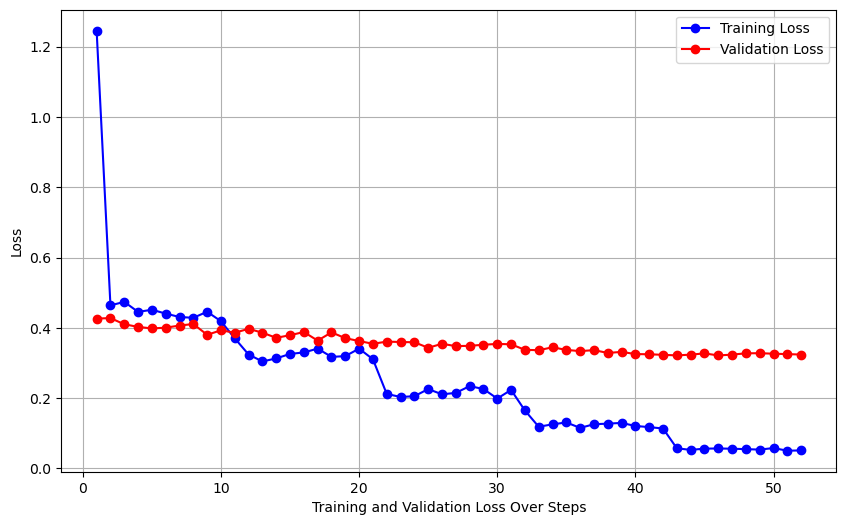

In [49]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

train_loss = [log['loss'] for log in log_history if 'loss' in log]
val_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
steps = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(steps, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Training and Validation Loss Over Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [51]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import gc

test_dataloader = DataLoader(datasets["test"], batch_size=16, collate_fn=data_collator)
forced_decoder_ids = processor.get_decoder_prompt_ids(language=language, task='transcribe')

model.eval()
for step, batch in enumerate(tqdm(test_dataloader)):
    with torch.amp.autocast('cuda'):
        with torch.no_grad():
            generated_tokens = (
                model.generate(
                    input_features=batch["input_features"].to("cuda"),
                    decoder_input_ids=batch["labels"][:, :4].to("cuda"),
                    forced_decoder_ids=forced_decoder_ids,
                    max_new_tokens=255,
                )
                .cpu()
                .numpy()
            )
            labels = batch["labels"].cpu().numpy()
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
            metric.add_batch(
                predictions=decoded_preds,
                references=decoded_labels,
            )
    del generated_tokens, labels, batch
    gc.collect()
wer = 100 * metric.compute()
print(f"{wer=}")

  0%|          | 0/27 [00:00<?, ?it/s]C:\Users\aton\anaconda3\Lib\site-packages\bitsandbytes\autograd\_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
100%|██████████| 27/27 [08:41<00:00, 19.32s/it]

wer=21.58999192897498


In [57]:
trainer.save_model('C:/Users/aton/OneDrive/Documents/Belajar/Python/Jupyter Notebook/Automatic Speech Recognition/Final-result/checkpoint-5245')

In [70]:
peft_model_id = 'C:/Users/aton/OneDrive/Documents/Belajar/Python/Jupyter Notebook/Automatic Speech Recognition/Final-result/checkpoint-5245'
peft_config = PeftConfig.from_pretrained(peft_model_id)
model = WhisperForConditionalGeneration.from_pretrained(peft_config.base_model_name_or_path, quantization_config=bnb_config, device_map='auto')
model = PeftModel.from_pretrained(model, peft_model_id)

In [71]:
import torch
import gradio as gr
from transformers import pipeline
from transformers import (
    WhisperTokenizer,
    WhisperProcessor,
)

tokenizer = WhisperTokenizer.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)
processor = WhisperProcessor.from_pretrained(peft_config.base_model_name_or_path, language=language, task=task)
feature_extractor = processor.feature_extractor

whisper_asr = pipeline('automatic-speech-recognition', model=model, chunk_length_s=30, stride_length_s=10, batch_size=32, tokenizer=tokenizer, feature_extractor=feature_extractor, generate_kwargs={"forced_decoder_ids": forced_decoder_ids})

In [ ]:
import librosa
import noisereduce as nr

def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int ((seconds % 3600) // 60)
    seconds = seconds % 60
    return f'{hours:02}:{minutes:02}:{seconds:06.3f}'.replace('.', ',')

def process_audio_and_create_txt(audio_filename, audio_type, whisper_asr, output_filename=None, noise=False):
    if noise:
        audio, sr = librosa.load(f'{audio_filename}.{audio_type}', sr=16000)
        reduced_noise_audio = nr.reduce_noise(y=audio, sr=sr)
        prediction = whisper_asr(reduced_noise_audio, return_timestamps=True)

    prediction = whisper_asr(f'{audio_filename}.{audio_type}', return_timestamps=True)
    
    txt_file_name = output_filename if output_filename else f'{audio_filename}.txt'

    with open(txt_file_name, 'w', encoding='utf-8') as txt_file:
        txt_file.write('Hasil Transkripsi\n\n')
        for chunk in prediction['chunks']:
            start, end = chunk['timestamp']
            start_time = format_time(start)
            end_time = format_time(end)
            text = chunk['text']
            txt_file.write(f'{start_time} --> {end_time}\n{text}\n\n')

In [ ]:
sample_audio = 'C:/Users/aton/OneDrive/Documents/Belajar/Python/Jupyter Notebook/Automatic Speech Recognition/Example'

process_audio_and_create_txt(sample_audio, 'mp3', whisper_asr)

C:\Users\aton\anaconda3\Lib\site-packages\transformers\models\whisper\generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


In [64]:
torch.cuda.empty_cache()